In [5]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

# also need scipy and scikit-learn
from utils import remove_all_ticks_and_labels

# import dataset

size of the training set is 2000


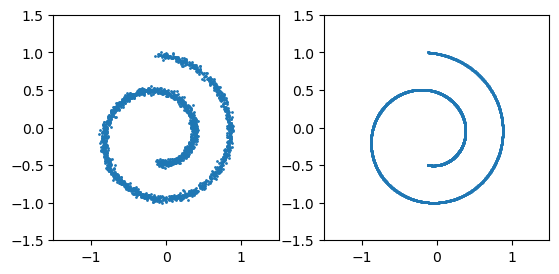

In [18]:
# visualize the manifold
from dataset_utils import load_unimodal_data, generate_2d_swiss_roll

dataset_size = int(2e3)
manifold_type = 'swiss_roll'
prior_with_noise = load_unimodal_data(
    dataset_size, 
    manifold_type, 
    offset=[0,0], 
    train_test_split=False, 
    normalize=True,
    positive_quadrant=False, 
    add_class_label=False, 
    plot=False,
    noise=0.3
    )
prior_without_noise = generate_2d_swiss_roll(dataset_size, rescaled=True)[1]

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*prior_with_noise.T, s=1)
ax[1].scatter(*prior_without_noise.T, s=1)
lim = 1.5; lims = [-lim, lim]
for a in ax:
    # remove_all_ticks_and_labels(a)
    a.set(xlim=lims, ylim=lims, aspect='equal')

# training process

In [30]:
# now train model on the 10D dataset
from prior_utils import forward_process
from utils import noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
    tb = SummaryWriter(run_dir)
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

# run

In [33]:
import json
from models import VariableDendriticCircuit

# define hyperparameter values
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# -------------------------- set model parameters -------------------------- #
model_name = 'unconditional-dendritic'
model_number = 61
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 2
epochs = 5e5
manifold_type = 'swiss_roll'
manifold_noise_amount = 0.3
dataset_size = int(2e3)
batch_size = 128
lr = 3e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic',
    'model_num': 60
}


# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'manifold_noise_amount': manifold_noise_amount,
    'dataset_size': f'{dataset_size:.0e}',
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = os.path.join(base_dir, 'core/model_description')
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)


from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
# dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
dataset = load_unimodal_data(
    dataset_size, 
    manifold_type, 
    offset=[0,0], 
    train_test_split=False, 
    normalize=True,
    positive_quadrant=False, 
    add_class_label=False, 
    plot=False,
    noise=manifold_noise_amount
    )

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

Using device: cuda
size of the training set is 2000
taking weights from pretrained model unconditional-dendritic_60!
model loaded!


Training model:   0%|          | 0/500000 [00:00<?, ?epochs/s]

training took 26521 seconds, which is 442.02 minutes.
model state dict saved in directory: /mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_weights/unconditional-dendritic_61.pt


# testing

model loaded!


<AxesSubplot: title={'center': 'samples'}>

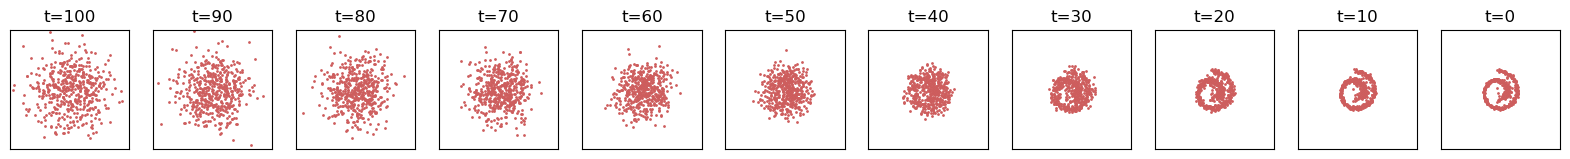

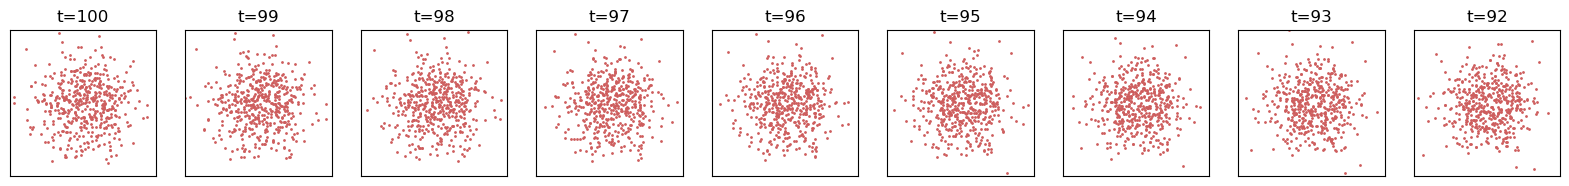

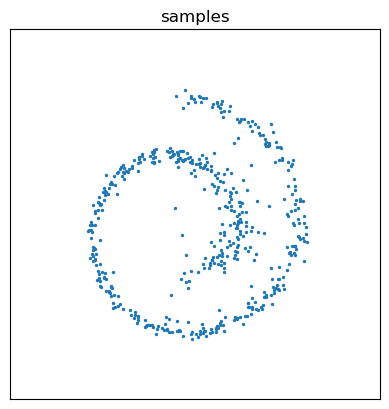

In [32]:
from prior_utils import p_sample_loop, p_sample_loop_snn
from prior_utils import forward_process  
from utils import load_model_weights
from models import VariableDendriticCircuit

sample_size = 5e2
lims = [-3,3]

# model = SNN3(num_hidden)
# model = load_model_weights(model, 'snn3', 2, device)

num_hidden = [3, 3, 3, 3, 3, 3, 4]
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
model = model.to(device)
model = load_model_weights(model, 'unconditional-dendritic', 60, device)

# model = NoiseConditionalEstimatorConcat(num_hidden)
# model = load_model_weights(model, 'unconditional-concat', 16, device)

x_seq = p_sample_loop(model, (int(sample_size), num_ambient_dims), num_steps, device)  # with sampling noise
# x_seq = p_sample_loop_snn(model, (int(sample_size), num_ambient_dims), num_steps, device)  # withouth sampling noise
x_seq = x_seq.detach().cpu().numpy()

fig, axes = plt.subplots(1, 11, figsize=(20, 3), sharey=True)
for i in range(0, 11):
    cur_x = x_seq[i * 10]
    ax = axes[i]
    ax.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='indianred', s=1);
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i*10}')
    
fig, axes = plt.subplots(1, 9, figsize=(20, 3), sharey=True)
i = 0
for ax in axes:
    ax.scatter(x_seq[i][:, 0], x_seq[i][:, 1],color='white',edgecolor='indianred', s=1)
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i}')
    i += 1

lims = [-1.5, 1.5]
fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq[-1].T, s=2)
ax.set(xlim=lims, ylim=lims, aspect='equal', title='samples')
remove_all_ticks_and_labels(ax)